In [175]:
import re
from pathlib import Path
import json
import random

import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ollama import Client
import pandas as pd
import numpy as np

from TinyRecursiveModels.models.losses import ACTLossHead
from TinyRecursiveModels.dataset.build_sudoku_dataset import DataProcessConfig, preprocess_data
from TinyRecursiveModels.models.recursive_reasoning.trm import (
    TinyRecursiveReasoningModel_ACTV1, 
    TinyRecursiveReasoningModel_ACTV1Carry, 
    TinyRecursiveReasoningModel_ACTV1InnerCarry
 )

In [176]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [177]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='mps')

In [178]:
ollama_client = Client()

In [179]:
LAB_DIR = Path(".")
DATA_ROOT = LAB_DIR / "data" / "sudoku-extreme-enhanced"

config = DataProcessConfig(
    output_dir=str(DATA_ROOT),
    subsample_size=10000,
    min_difficulty=None,
    num_aug=2,
)

train_inputs_path = DATA_ROOT / "train" / "all__inputs.npy"

if not train_inputs_path.exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    preprocess_data(config)
else:
    print(f"Using cached dataset at {DATA_ROOT}")

Using cached dataset at data/sudoku-extreme-enhanced


In [180]:
def grid_to_text(tokens, side=None):
    arr = np.array(tokens, dtype=np.int64)
    if side is not None:
        arr = arr.reshape(side, side)
    decoded = arr - 1
    return "\n".join(" ".join(str(int(x)) for x in row) for row in decoded)


def load_split(base_dir, split="train"):
    split_dir = Path(base_dir) / split
    meta = json.loads((split_dir / "dataset.json").read_text())
    inputs = np.load(split_dir / "all__inputs.npy")
    labels = np.load(split_dir / "all__labels.npy")
    puzzle_ids = np.load(split_dir / "all__puzzle_identifiers.npy")
    return meta, inputs, labels, puzzle_ids


meta_train, train_inputs, train_labels, train_puzzle_ids = load_split(DATA_ROOT, "train")
meta_test, test_inputs, test_labels, test_puzzle_ids = load_split(DATA_ROOT, "test")
dataset_meta = meta_train
dataset_meta

{'pad_id': 0,
 'ignore_label_id': 0,
 'blank_identifier_id': 0,
 'vocab_size': 11,
 'seq_len': 81,
 'num_puzzle_identifiers': 1,
 'total_groups': 10000,
 'mean_puzzle_examples': 1.0,
 'total_puzzles': 10000,
 'sets': ['all']}

In [181]:
class NumpyPuzzleDataset(Dataset):
    def __init__(self, inputs, labels, puzzle_ids):
        self.inputs = inputs
        self.labels = labels
        self.puzzle_ids = puzzle_ids

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.inputs[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.tensor(self.puzzle_ids[idx], dtype=torch.long),
        )


def collate_batch(batch):
    inputs, labels, puzzle_ids = zip(*batch)
    inputs = torch.stack(inputs, dim=0)
    labels = torch.stack(labels, dim=0)
    puzzle_ids = torch.stack(puzzle_ids, dim=0)

    return {
        'inputs': inputs,
        'labels': labels,
        'puzzle_identifiers': puzzle_ids
    }


def make_loaders(batch_size=32):
    train_ds = NumpyPuzzleDataset(train_inputs, train_labels, train_puzzle_ids)
    test_ds = NumpyPuzzleDataset(test_inputs, test_labels, test_puzzle_ids)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    return train_loader, test_loader


loaders = make_loaders(batch_size=32)
{'train_batches': len(loaders[0]), 'test_batches': len(loaders[1])}

{'train_batches': 938, 'test_batches': 13213}

In [182]:
def softmax_cross_entropy_masked(logits, labels, ignore_index: int = -100, valid_mask=None):
    # Compute CE in float32 and apply optional mask
    loss = torch.nn.functional.cross_entropy(
        logits.to(torch.float32).view(-1, logits.shape[-1]),
        labels.to(torch.long).view(-1),
        ignore_index=ignore_index,
        reduction='none',
    ).view(labels.shape)
    if valid_mask is None:
        return loss
    return loss * valid_mask


def build_trm(meta, hidden_size=64, heads=4, halt_steps=2, H_cycles=2, L_cycles=2, L_layers=2):
    cfg = dict(
        batch_size=32,
        seq_len=meta['seq_len'],
        puzzle_emb_ndim=0,
        num_puzzle_identifiers=1,
        vocab_size=meta['vocab_size'],
        H_cycles=H_cycles,
        L_cycles=L_cycles,
        H_layers=0,
        L_layers=L_layers,
        hidden_size=hidden_size,
        expansion=2,
        num_heads=heads,
        pos_encodings='rope',
        halt_max_steps=halt_steps,
        halt_exploration_prob=0.05,
        forward_dtype='float32',
        mlp_t=True,
        puzzle_emb_len=0,  # keep seq length aligned when puzzle_emb_ndim=0
        no_ACT_continue=True,
    )
    model = TinyRecursiveReasoningModel_ACTV1(cfg)
    return ACTLossHead(model, loss_type='softmax_cross_entropy_masked').to(device)


def move_batch(batch):
    return {k: v.to(device) for k, v in batch.items()}


def move_carry_to_device(carry: TinyRecursiveReasoningModel_ACTV1Carry, device):
    inner = TinyRecursiveReasoningModel_ACTV1InnerCarry(
        z_H=carry.inner_carry.z_H.to(device),
        z_L=carry.inner_carry.z_L.to(device),
    )
    current_data = {k: v.to(device) for k, v in carry.current_data.items()}
    return TinyRecursiveReasoningModel_ACTV1Carry(
        inner_carry=inner,
        steps=carry.steps.to(device),
        halted=carry.halted.to(device),
        current_data=current_data,
    )


def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    for batch in loader:
        batch = move_batch(batch)
        carry = model.initial_carry(batch)
        carry = move_carry_to_device(carry, batch['inputs'].device)
        carry, loss, metrics, outputs, _ = model(return_keys=['preds'], carry=carry, batch=batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item()
        preds = outputs['preds']
        total_correct += (preds == batch['labels']).sum().item()
        total_tokens += batch['labels'].numel()
    return {'loss': total_loss / max(len(loader), 1), 'token_acc': total_correct / max(total_tokens, 1)}


def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in loader:
            batch = move_batch(batch)
            carry = model.initial_carry(batch)
            carry = move_carry_to_device(carry, batch['inputs'].device)
            carry, loss, metrics, outputs, _ = model(return_keys=['preds'], carry=carry, batch=batch)
            total_loss += loss.item()
            preds = outputs['preds']
            total_correct += (preds == batch['labels']).sum().item()
            total_tokens += batch['labels'].numel()
    return {'loss': total_loss / max(len(loader), 1), 'token_acc': total_correct / max(total_tokens, 1)}


def predict_batch(model, batch):
    model.eval()
    with torch.no_grad():
        batch = move_batch(batch)
        carry = model.initial_carry(batch)
        carry = move_carry_to_device(carry, batch['inputs'].device)
        carry, _, _, outputs, _ = model(return_keys=['preds'], carry=carry, batch=batch)
        return outputs['preds'].cpu().numpy()

In [183]:
trained_model = None
training_logs = []

print(f"Training sudoku (seq_len={dataset_meta['seq_len']})")
# Increased capacity: hidden_size 128, L_layers 2
# Increased reasoning: halt_steps 4
model = build_trm(dataset_meta, hidden_size=128, heads=4, halt_steps=4, L_layers=2)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=5e-5,
)
train_loader, test_loader = loaders
epochs = 5

# Checkpointing setup
checkpoint_dir = LAB_DIR / 'checkpoints'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# If a final model exists, try to load it and skip training entirely
final_path = checkpoint_dir / 'sudoku_final.pt'
skip_training = False
if final_path.exists():
    print(f"Found final model {final_path}, attempting to load...")
    try:
        ckpt = torch.load(final_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        if 'optimizer_state_dict' in ckpt:
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])

            # Move optimizer state tensors to the correct device
            for state in optimizer.state.values():
                for k, v in list(state.items()):
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)

        training_logs = ckpt.get('training_logs', [])
        trained_model = model
        skip_training = True
        print(f"Loaded final model from {final_path}. Skipping training.")
    except Exception as e:
        print(f"Could not load final model (may be incompatible): {e}")
        print("Will attempt to resume from checkpoints or train from scratch.")

# Try to find the latest checkpoint (used if final did not load)
ckpt_files = sorted(checkpoint_dir.glob('sudoku_epoch_*.pt'))
start_epoch = 1

# Note: Loading will fail if architecture changed (e.g. hidden_size 96 -> 128)
if (not skip_training) and ckpt_files:
    def epoch_from_path(p):
        m = re.search(r"(\d+)\.pt$", p.name)
        return int(m.group(1)) if m else -1
    
    epochs_done = [epoch_from_path(p) for p in ckpt_files]
    last_epoch = max(epochs_done)

    if last_epoch > 0:
        latest = checkpoint_dir / f'sudoku_epoch_{last_epoch:03d}.pt'
        print(f"Found checkpoint {latest}, checking compatibility...")
        try:
            ckpt = torch.load(latest, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])

            # Move optimizer state tensors to the correct device
            for state in optimizer.state.values():
                for k, v in list(state.items()):
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)

            training_logs = ckpt.get('training_logs', [])
            start_epoch = ckpt.get('epoch', last_epoch) + 1
            print(f"Resuming from epoch {start_epoch}")
        except Exception as e:
            print(f"Could not load checkpoint (likely arch change): {e}")
            print("Starting from scratch.")


Training sudoku (seq_len=81)
Found final model checkpoints/sudoku_final.pt, attempting to load...
Loaded final model from checkpoints/sudoku_final.pt. Skipping training.


In [184]:
if not skip_training:
    for epoch in range(start_epoch, epochs + 1):
        train_metrics = train_epoch(model, train_loader, optimizer)
        val_metrics = evaluate(model, test_loader)
        current_lr = optimizer.param_groups[0]['lr']
        training_logs.append({
            'task': 'sudoku9',
            'epoch': epoch,
            'lr': current_lr,
            **{f"train_{k}": v for k, v in train_metrics.items()},
            **{f"val_{k}": v for k, v in val_metrics.items()}
        })
        print(
            f"epoch {epoch:02d} | lr {current_lr:.2e} | "
            f"train_loss {train_metrics['loss']:.3f} acc {train_metrics['token_acc']:.3f} | "
            f"val_loss {val_metrics['loss']:.3f} acc {val_metrics['token_acc']:.3f}"
        )

        if scheduler is not None:
            scheduler.step(val_metrics['loss'])

        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            ckpt = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'training_logs': training_logs,
            }
            path = checkpoint_dir / f'sudoku_epoch_{epoch:03d}.pt'
            torch.save(ckpt, path)
            print(f"Saved checkpoint for epoch {epoch} to {path}")
else:
    print(f"Skipping training because final model was loaded from {final_path}")

Skipping training because final model was loaded from checkpoints/sudoku_final.pt


In [185]:
if not skip_training:
    trained_model = model

    # Determine last completed epoch safely
    final_epoch = training_logs[-1]['epoch'] if training_logs else 0

    # Save final model
    final_path = checkpoint_dir / 'sudoku_final.pt'
    torch.save({
        'epoch': final_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_logs': training_logs,
    }, final_path)
    print(f"Saved final model to {final_path}")

    # Save training logs to JSON and CSV
    logs_path = checkpoint_dir / 'training_logs.json'
    with open(logs_path, 'w') as f:
        json.dump(training_logs, f, indent=2)
    print(f"Saved training logs to {logs_path}")

    csv_path = checkpoint_dir / 'training_logs.csv'
    pd.DataFrame(training_logs).to_csv(csv_path, index=False)
    print(f"Saved training logs CSV to {csv_path}")
else:
    print(f"Using loaded final model from {final_path}; skipping saving.")
    trained_model = model

Using loaded final model from checkpoints/sudoku_final.pt; skipping saving.


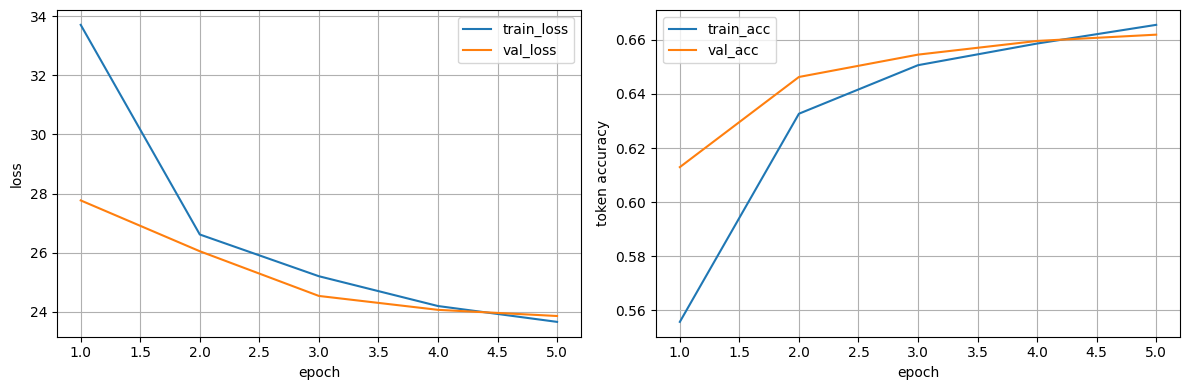

In [186]:
df_logs = pd.DataFrame(training_logs).sort_values('epoch')
df_logs = df_logs.set_index('epoch')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

if 'train_loss' in df_logs.columns and 'val_loss' in df_logs.columns:
    plt.plot(df_logs.index, df_logs['train_loss'], label='train_loss')
    plt.plot(df_logs.index, df_logs['val_loss'], label='val_loss')

plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2)

if 'train_token_acc' in df_logs.columns and 'val_token_acc' in df_logs.columns:
    plt.plot(df_logs.index, df_logs['train_token_acc'], label='train_acc')
    plt.plot(df_logs.index, df_logs['val_token_acc'], label='val_acc')

plt.xlabel('epoch'); plt.ylabel('token accuracy'); plt.legend(); plt.grid(True)
fig_path = checkpoint_dir / 'training_history.png'
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

In [187]:
def render_sample(meta, tensor_1d):
    side = int(np.sqrt(meta['seq_len']))
    return grid_to_text(tensor_1d, side=side)

batch = next(iter(test_loader))
preds = predict_batch(trained_model, batch)
rows = []

for i in range(min(2, len(preds))):
    rows.append({
        'input': render_sample(dataset_meta, batch['inputs'][i].numpy()),
        'target': render_sample(dataset_meta, batch['labels'][i].numpy()),
        'prediction': render_sample(dataset_meta, preds[i])
    })

json.dumps(rows, indent=2)

'[\n  {\n    "input": "0 9 0 0 0 1 2 0 0\\n0 3 0 0 2 8 4 0 6\\n0 6 0 0 0 0 0 8 0\\n0 7 0 0 0 0 1 4 0\\n0 2 0 0 5 0 7 0 0\\n0 0 3 0 0 0 0 0 2\\n0 1 0 9 0 0 0 0 0\\n0 0 0 7 0 5 0 0 0\\n0 8 7 2 0 6 0 0 4",\n    "target": "5 9 8 4 6 1 2 7 3\\n7 3 1 5 2 8 4 9 6\\n2 6 4 3 9 7 5 8 1\\n8 7 9 6 3 2 1 4 5\\n4 2 6 1 5 9 7 3 8\\n1 5 3 8 7 4 9 6 2\\n6 1 5 9 4 3 8 2 7\\n3 4 2 7 8 5 6 1 9\\n9 8 7 2 1 6 3 5 4",\n    "prediction": "8 9 8 6 6 1 2 5 3\\n7 3 1 5 2 8 4 9 6\\n2 6 2 4 9 9 5 8 1\\n9 7 8 3 6 2 1 4 5\\n1 2 4 8 5 9 7 3 9\\n8 5 3 1 4 7 8 6 2\\n5 1 2 9 8 3 6 7 7\\n3 4 9 7 1 5 3 1 1\\n9 8 7 2 1 6 5 5 4"\n  },\n  {\n    "input": "0 9 0 0 0 0 0 0 3\\n0 0 0 0 8 0 9 0 0\\n0 6 0 7 0 3 2 0 0\\n0 0 4 0 0 5 0 0 8\\n5 0 0 0 0 0 6 3 0\\n0 0 0 0 0 9 0 5 0\\n0 8 0 0 1 0 0 0 4\\n1 0 0 0 0 7 8 2 0\\n0 2 3 9 0 0 0 7 0",\n    "target": "2 9 7 4 5 6 1 8 3\\n3 4 5 2 8 1 9 6 7\\n8 6 1 7 9 3 2 4 5\\n9 3 4 6 2 5 7 1 8\\n5 1 2 8 7 4 6 3 9\\n6 7 8 1 3 9 4 5 2\\n7 8 6 5 1 2 3 9 4\\n1 5 9 3 4 7 8 2 6\\n4 2 3 9 6 8 5 7 1",\

In [188]:
def parse_grid(text, side):
    """Parse an LLM text response into a side x side numpy grid of ints.
    Accepts lines separated by newlines and cells separated by spaces or commas.
    Returns None if parsing fails or the shape/value constraints are violated.
    """
    if not text:
        return None
    lines = [ln.strip() for ln in text.strip().splitlines() if ln.strip()]
    if len(lines) < 1:
        return None
    # Use first line that looks numeric-rich; otherwise concatenate
    candidate_lines = lines
    cells = []
    for ln in candidate_lines:
        parts = [p for p in ln.replace(',', ' ').split(' ') if p]
        if len(parts) == side * side:
            cells = parts
            break
        cells.extend(parts)
    if len(cells) != side * side:
        return None
    try:
        arr = np.array([int(p) for p in cells], dtype=np.int64)
    except ValueError:
        return None
    # Ensure values are 0-9 for Sudoku; allow 0 as blank
    if not ((arr >= 0) & (arr <= 9)).all():
        return None
    try:
        return arr.reshape(side, side)
    except ValueError:
        return None

In [189]:
def build_prompt(meta, grid_in, strategy='zero'):
    side = int(np.sqrt(meta['seq_len']))
    grid_txt = grid_to_text(grid_in, side=side)
    header = f"Fill the {side}x{side} Sudoku. Zeros/blanks mean empty cells. Return the completed grid with spaces separated."
    prompt = f"{header}\nGrid:\n{grid_txt}\n"
    if strategy == 'cot':
        prompt += (
            "Let's think step by step to solve the Sudoku puzzle. "
            "Return only the final grid in a plain numeric format: 9 lines each with 9 numbers separated by spaces. "
            "Do NOT use code fences or extra commentary."
        )
    else:
        # 'zero' or other non-explanatory strategies
        prompt += (
            "Return only the final grid in a plain numeric format: 9 lines each with 9 numbers separated by spaces. "
            "Do NOT include explanations or code fences."
        )
    return prompt


def evaluate_llm(meta, max_examples=5, strategies=("zero", "cot")):
    """Evaluate LLMs on a small subset of test examples."""
    side = int(np.sqrt(meta['seq_len']))
    results = []
    total = min(max_examples, len(test_inputs))

    # Use a single, canonical model name
    model_name = 'ministral-3:3b'

    for idx, (inp, out) in enumerate(zip(test_inputs, test_labels)):
        if idx >= max_examples:
            break

        print(f"[LLM eval] example {idx + 1}/{total}")

        for strat in strategies:
            prompt = build_prompt(meta, inp, strategy=strat)
            resp = None
            content = ''
            error_msg = None

            # Call the single model and handle errors
            try:
                resp = ollama_client.chat(model='ministral-3:3b', messages=[{'role': 'user', 'content': prompt}])
            except Exception as e:
                error_msg = e
                resp = None

            if resp is None and error_msg is not None:
                content = f"ERROR: {error_msg}"
            else:
                # Robust extraction of text content from various response shapes
                try:
                    if isinstance(resp, dict):
                        # Try several keys people use
                        content = (
                            resp.get('message', {}) and resp.get('message', {}).get('content', '')
                        ) or resp.get('content', '') or ''
                    elif hasattr(resp, 'message'):
                        msg = resp.message
                        if isinstance(msg, dict):
                            content = msg.get('content', '') or ''
                        elif isinstance(msg, str):
                            content = msg
                        else:
                            content = str(msg)
                    else:
                        content = str(resp)
                except Exception as e:
                    content = f"ERROR_EXTRACTING_CONTENT: {e}"

            # If content is empty, keep a repr of the raw response for debugging
            raw_repr = None
            try:
                raw_repr = repr(resp)
            except Exception:
                raw_repr = None

            # Try to extract a numeric grid from code fences or digit sequences
            parsed = None
            if content and not content.startswith('ERROR'):
                try:
                    # Look for fenced code blocks first (``` ... ```) 
                    code_blocks = re.findall(r"```(?:[^\n]*\n)?(.*?)```", content, flags=re.S)
                    candidate_texts = code_blocks if code_blocks else [content]

                    for txt in reversed(candidate_texts):  # prefer last block
                        nums = re.findall(r"\d+", txt)
                        if len(nums) >= side * side:
                            nums = nums[:side * side]
                            s = ' '.join(nums)
                            parsed = parse_grid(s, side)
                            if parsed is not None:
                                break

                    # Fallback: try extracting all digits from the full content
                    if parsed is None:
                        nums = re.findall(r"\d+", content)
                        if len(nums) >= side * side:
                            nums = nums[:side * side]
                            s = ' '.join(nums)
                            parsed = parse_grid(s, side)
                except Exception:
                    parsed = None

            token_acc = None

            if parsed is not None:
                parsed_tokens = (parsed + 1).reshape(-1)
                token_acc = float((parsed_tokens == out.reshape(-1)).mean())

            results.append({
                'task': 'sudoku9',
                'example_id': idx,
                'strategy': strat,
                'prompt': prompt,
                'raw_response': content if content else (raw_repr if raw_repr is not None else ''),
                'parsed': parsed.tolist() if parsed is not None else None,
                'token_acc': token_acc
            })

    return results

In [190]:
llm_results = evaluate_llm(dataset_meta, max_examples=5, strategies=("zero", "cot"))

# Save raw LLM results to JSON
checkpoint_dir = LAB_DIR / 'checkpoints'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
llm_path = checkpoint_dir / 'llm_results.json'
with open(llm_path, 'w') as f:
    json.dump(llm_results, f, indent=2)
print(f"Saved LLM results to {llm_path}")

llm_results[:1]

[LLM eval] example 1/5
[LLM eval] example 2/5
[LLM eval] example 3/5
[LLM eval] example 4/5
[LLM eval] example 5/5
Saved LLM results to checkpoints/llm_results.json


[{'task': 'sudoku9',
  'example_id': 0,
  'strategy': 'zero',
  'prompt': 'Fill the 9x9 Sudoku. Zeros/blanks mean empty cells. Return the completed grid with spaces separated.\nGrid:\n0 9 0 0 0 1 2 0 0\n0 3 0 0 2 8 4 0 6\n0 6 0 0 0 0 0 8 0\n0 7 0 0 0 0 1 4 0\n0 2 0 0 5 0 7 0 0\n0 0 3 0 0 0 0 0 2\n0 1 0 9 0 0 0 0 0\n0 0 0 7 0 5 0 0 0\n0 8 7 2 0 6 0 0 4\nReturn only the final grid in a plain numeric format: 9 lines each with 9 numbers separated by spaces. Do NOT include explanations or code fences.',
  'raw_response': "role='assistant' content='2 9 5 8 4 1 2 7 3\\n3 3 1 6 2 8 4 9 6\\n4 6 8 5 9 7 3 8 1\\n7 7 9 3 8 6 1 4 2\\n2 2 4 1 5 9 7 5 8\\n5 5 3 4 6 2 8 1 2\\n6 1 7 9 3 4 5 2 9\\n8 4 2 7 1 5 6 3 0\\n9 8 7 2 3 6 4 5 4' thinking=None images=None tool_name=None tool_calls=None",
  'parsed': [[2, 9, 5, 8, 4, 1, 2, 7, 3],
   [3, 3, 1, 6, 2, 8, 4, 9, 6],
   [4, 6, 8, 5, 9, 7, 3, 8, 1],
   [7, 7, 9, 3, 8, 6, 1, 4, 2],
   [2, 2, 4, 1, 5, 9, 7, 5, 8],
   [5, 5, 3, 4, 6, 2, 8, 1, 2],
   [6, 1, 7

In [191]:
trm_eval = []
metrics = evaluate(trained_model, test_loader)
trm_eval.append({'task': 'sudoku9', 'model': 'trm', **metrics})

In [192]:
trm_df = pd.DataFrame(trm_eval)
llm_df = pd.DataFrame([r for r in llm_results if r.get('token_acc') is not None])

llm_summary = pd.DataFrame(columns=['task','strategy','token_acc'])

# Save TRM and LLM summaries/results
checkpoint_dir = LAB_DIR / 'checkpoints'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
trm_df.to_csv(checkpoint_dir / 'trm_eval.csv', index=False)
trm_df.to_json(checkpoint_dir / 'trm_eval.json', orient='records', indent=2)
print(f"Saved TRM evaluation to {checkpoint_dir / 'trm_eval.json'}")

if not llm_df.empty:
    llm_df.to_csv(checkpoint_dir / 'llm_results_filtered.csv', index=False)
    llm_df.to_json(checkpoint_dir / 'llm_results_filtered.json', orient='records', indent=2)
    print(f"Saved filtered LLM results to {checkpoint_dir / 'llm_results_filtered.json'}")

llm_summary.to_csv(checkpoint_dir / 'llm_summary.csv', index=False)
llm_summary.to_json(checkpoint_dir / 'llm_summary.json', orient='records', indent=2)
print(f"Saved LLM summary to {checkpoint_dir / 'llm_summary.json'}")

trm_df, llm_summary.head()

Saved TRM evaluation to checkpoints/trm_eval.json
Saved filtered LLM results to checkpoints/llm_results_filtered.json
Saved LLM summary to checkpoints/llm_summary.json


(      task model       loss  token_acc
 0  sudoku9   trm  23.862578   0.661921,
 Empty DataFrame
 Columns: [task, strategy, token_acc]
 Index: [])

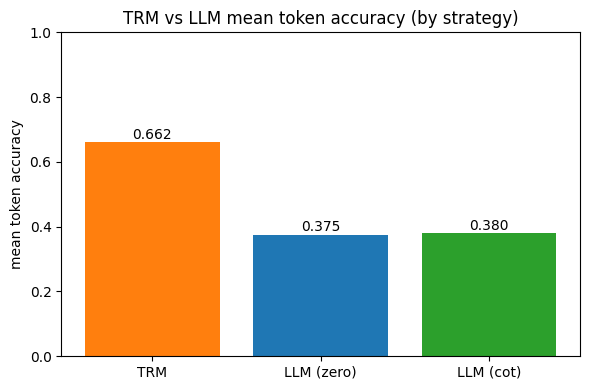

Saved comparison plot to checkpoints/trm_vs_llm_three.png


In [193]:
trm_mean = trm_df['token_acc'].mean()

# Safely compute LLM means — handle empty DataFrame or missing columns
if not isinstance(llm_df, pd.DataFrame) or llm_df.empty or not {'strategy', 'token_acc'}.issubset(llm_df.columns):
    llm_zero_mean = np.nan
    llm_cot_mean = np.nan
    print("Warning: no valid LLM 'strategy'/'token_acc' data found; LLM means set to NaN.")
else:
    llm_zero_mean = llm_df.loc[llm_df['strategy'] == 'zero', 'token_acc'].mean()
    llm_cot_mean = llm_df.loc[llm_df['strategy'] == 'cot', 'token_acc'].mean()

comp = pd.DataFrame({
    'model': ['TRM', 'LLM (zero)', 'LLM (cot)'],
    'mean_token_acc': [trm_mean, llm_zero_mean, llm_cot_mean]
})

plt.figure(figsize=(6,4))
bars = plt.bar(comp['model'], comp['mean_token_acc'].fillna(0), color=['C1', 'C0', 'C2'])
plt.ylim(0, 1)
for i, v in enumerate(comp['mean_token_acc']):
    label = f"{v:.3f}" if not np.isnan(v) else 'n/a'
    plt.text(i, (0 if np.isnan(v) else v) + 0.01, label, ha='center')
plt.ylabel('mean token accuracy')
plt.title('TRM vs LLM mean token accuracy (by strategy)')

out_path = checkpoint_dir / 'trm_vs_llm_three.png'
plt.tight_layout()
plt.savefig(out_path)
plt.show()
print(f"Saved comparison plot to {out_path}")